## 1. 필수 라이브러리 임포트 및 환경 설정
- .env에 openai api key 저장: sk-.....

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from dotenv import load_dotenv
from langchain.prompts import PromptTemplate
# from langchain.llms import OpenAI
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnableParallel, RunnableMap, RunnablePassthrough, RunnableLambda
from dotenv import load_dotenv
from langchain_teddynote import logging
from langchain_teddynote.messages import stream_response

# env 파일 읽기
load_dotenv()

# OpenAI API 키 가져오기
openai_api_key = os.getenv("OPENAI_API_KEY")

# 프로젝트 이름을 입력합니다. 
# - 로깅용 내부망에서 안됨
# - Prompt, Output에 대한 token 사용량 및 과금 정보 추적 가능
# logging.langsmith("AI_report", set_enable=True)

## 2. Sample Data 생성
- postgre와 연결 필요

In [6]:
import os
import pandas as pd
import numpy as np

# Random seed 설정 for reproducibility
np.random.seed(42)

# 회사 및 업종 정보 생성
num_companies = 100  # 총 100개의 회사 생성
company_names = [f'Company_{i+1}' for i in range(num_companies)]  # 회사명 리스트 생성
industries = ['Manufacturing', 'Retail', 'Technology', 'Healthcare', 'Finance']  # 업종 리스트

# 각 회사에 대한 고정된 업종 리스트 생성
company_industries = [np.random.choice(industries) for _ in range(num_companies)]  # 각 회사의 업종을 무작위로 할당

# 날짜 생성 (2021-01 ~ 2024-09)
dates = pd.date_range(start="2021-01-01", end="2024-09-01", freq='MS').strftime("%Y-%m").tolist()  # 월별 날짜 리스트 생성

# 기본 정보 데이터 생성 함수 정의
def generate_basic_data(company, industry, date):
    base_asset_value = 30000  # 기본 총자산 값 설정
    total_assets = round(base_asset_value * (1 + np.random.normal(0, 0.05)), 0)  # 기본 총자산 값에서 5% 변동 (정규분포 이용, 소수점 없이)
    revenue = round(np.random.uniform(1000, 10000), 0)  # 1천만원 ~ 1억원 사이의 매출액 값 설정 (소수점 없이)
    operating_profit = round(revenue * np.random.uniform(-0.2, 0.2), 0)  # 영업이익 = 매출액의 -20%~20%로 계산 (소수점 없이)
    net_income = round(operating_profit * np.random.uniform(-0.5, 0.8), 0)  # 당기순이익 = 영업이익의 -50%~80%로 계산 (소수점 없이)
    short_term_loans = round(np.random.uniform(500, 5000), 0)  # 단기차입금 (500만원 ~ 5000만원 사이, 소수점 없이)
    long_term_loans = round(np.random.uniform(1000, 10000), 0)  # 장기차입금 (1000만원 ~ 1억원 사이, 소수점 없이)
    total_loans = short_term_loans + long_term_loans  # 총 차입금 계산
    loan_to_sales = round((total_loans / revenue) * 100, 2)  # 매출대비차입금 비율
    working_capital_turnover = round(np.random.uniform(1, 5), 2)  # 운전자금회전율 (1~5회)
    operating_cash_flow = round(np.random.uniform(500, 5000), 0)  # 영업활동현금흐름 (500만원 ~ 5000만원 사이, 소수점 없이)
    net_cash_flow = round(operating_cash_flow - total_loans, 0)  # 순현금흐름 (영업활동현금흐름 - 총 차입금, 소수점 없이)
    ar_balance = round(np.random.uniform(1000, 5000), 0)  # 월별 매출채권 규모 (1000만원 ~ 5000만원, 소수점 없이)
    ar_collection_period = round(np.random.uniform(30, 90), 0)  # 월별 매출채권 회수기일 (30일 ~ 90일, 소수점 없이)
    ap_balance = round(np.random.uniform(800, 4000), 0)  # 월별 매입채무 규모 (800만원 ~ 4000만원, 소수점 없이)
    ap_payment_period = round(np.random.uniform(20, 80), 0)  # 월별 매입채무 회수기일 (20일 ~ 80일, 소수점 없이)
    
    return {
        '기업명': company,
        '업종': industry,
        '날짜': date,
        # 성장성
        '매출액증가율': round(np.random.uniform(5, 15), 2),  # 5~15% 사이의 매출액증가율 값
        '총자산증가율': round(np.random.uniform(3, 10), 2),  # 3~10% 사이의 총자산증가율 값
        '총자산': int(total_assets),  # 소수점 없이 월별 정수형 총자산 값
        '매출액': int(revenue),  # 소수점 없이 정수형 월별 매출액 값
        # 수익성
        '영업이익': int(operating_profit),  # 영업이익 추가 (정수형)
        '영업이익률': round(operating_profit / revenue * 100, 2) if revenue != 0 else round(np.random.uniform(-20, 20), 2),  # 영업이익률 추가 (음수 가능)
        '당기순이익': int(net_income),  # 당기순이익 추가 (정수형)
        '당기순이익률': round(net_income / revenue * 100, 2) if revenue != 0 else round(np.random.uniform(-30, 30), 2),  # 당기순이익률 추가 (음수 가능)
        # 재무 안정성
        '단기차입금': int(short_term_loans),  # 단기차입금 추가
        '장기차입금': int(long_term_loans),  # 장기차입금 추가
        '매출대비차입금': loan_to_sales,  # 매출대비차입금 비율 추가
        '운전자금회전율': working_capital_turnover,  # 운전자금회전율 추가
        # 인적 관리
        '인원수': np.random.randint(50, 300),  # 50~300명 사이의 임직원 수 설정
        '월평균급여액': round(np.random.uniform(200, 500), 1),  # 200~500만원 사이의 월평균 급여액 (소수점 없이)
        '월매출창출액': round(np.random.uniform(5000, 20000), 1),  # 5000~20000만원 사이의 월 매출 창출액 (소수점 없이)
        # 현금흐름
        '영업활동현금흐름/매출액': round(np.random.uniform(0.05, 0.2), 2),  # 5~20% 사이의 영업활동현금흐름/매출액 비율
        '영업활동현금흐름': int(operating_cash_flow),  # 영업활동현금흐름 추가
        '순현금흐름': int(net_cash_flow),  # 순현금흐름 추가
        # 거래처 안정성
        '월별_매출채권_규모': int(ar_balance),  # 월별 매출채권 규모
        '월별_매출채권_회수기일': int(ar_collection_period),  # 월별 매출채권 회수기일
        '월별_매입채무_규모': int(ap_balance),  # 월별 매입채무 규모
        '월별_매입채무_회수기일': int(ap_payment_period),  # 월별 매입채무 회수기일
    }

# 기본 정보 데이터 생성
basic_data = [
    generate_basic_data(company, industry, date)  # 각 회사와 날짜별로 기본 정보를 생성
    for company, industry in zip(company_names, company_industries)
    for date in dates
]

# 기본 정보 데이터프레임 생성
df_company_info = pd.DataFrame(basic_data)  # 회사 기본 정보로 데이터프레임 생성

# 데이터프레임 출력
print(df_company_info)

# 거래처 정보 데이터 생성 함수 정의
def generate_partner_data(company, date):
    # 상위 5개 매출처 및 매입처 정보 무작위로 생성
    sales_companies = list(np.random.choice(sales_partner_pool, 5, replace=False))
    purchase_companies = list(np.random.choice(purchase_partner_pool, 5, replace=False))

    # 각 매출처 및 매입처의 신용등급을 무작위로 선택
    sales_grades = list(np.random.choice(['AAA', 'AA+', 'AA', 'A+', 'A', 'BBB+', 'BBB', 'BB', 'B', 'CCC-'], 5, replace=False))
    purchase_grades = list(np.random.choice(['AAA', 'AA+', 'AA', 'A+', 'A', 'BBB+', 'BBB', 'BB', 'B', 'CCC-'], 5, replace=False))

    # 매출처 및 매입처의 집중도를 Dirichlet 분포를 이용해 생성하고, 총합이 100%가 되도록 정규화
    sales_concentrations = list(np.round(np.random.dirichlet(np.ones(5), 1)[0] * 100, 2))
    sales_concentrations = list(np.round(np.array(sales_concentrations) / sum(sales_concentrations) * 100, 2))

    purchase_concentrations = list(np.round(np.random.dirichlet(np.ones(5), 1)[0] * 100, 2))
    purchase_concentrations = list(np.round(np.array(purchase_concentrations) / sum(purchase_concentrations) * 100, 2))

    # 매출처 및 매입처 정보 반환 (각 회사 당 5개)
    return [
        {
            '기업명': company,
            '날짜': date,
            '매출처_회사명': sales_companies[i],
            '매출처_신용등급': sales_grades[i],
            '매출처_집중도': sales_concentrations[i],
            '매입처_회사명': purchase_companies[i],
            '매입처_신용등급': purchase_grades[i],
            '매입처_집중도': purchase_concentrations[i]
        }
        for i in range(5)
    ]

# 회사명 리스트에서 중복을 최소화하며 선택할 수 있도록 셋 생성
sales_partner_pool = list(set(f'SalesPartner_{i+1}' for i in range(200)))  # 매출처 Pool 생성 (200개)
purchase_partner_pool = list(set(f'PurchasePartner_{i+1}' for i in range(200)))  # 매입처 Pool 생성 (200개)

# 거래처 정보 데이터 생성
partner_data = [
    partner  # 각 회사와 날짜별로 거래처 정보 생성
    for company in company_names
    for date in dates
    for partner in generate_partner_data(company, date)
]

# 거래처 정보 데이터프레임 생성
df_partner_info = pd.DataFrame(partner_data)  # 거래처 정보로 데이터프레임 생성

# 샘플 출력
print(df_company_info.head())  # 회사 기본 정보 샘플 출력
print(df_partner_info.head())  # 거래처 정보 샘플 출력

              기업명             업종       날짜  매출액증가율  총자산증가율    총자산   매출액  영업이익  \
0       Company_1     Healthcare  2021-01    7.56    3.28  28655  4337   293   
1       Company_1     Healthcare  2021-02    6.61    9.51  29832  1283    70   
2       Company_1     Healthcare  2021-03   10.34    6.39  29378  8950  -629   
3       Company_1     Healthcare  2021-04   11.10    6.52  27902  3909    29   
4       Company_1     Healthcare  2021-05   12.98    4.06  30507  5030   106   
...           ...            ...      ...     ...     ...    ...   ...   ...   
4495  Company_100  Manufacturing  2024-05   14.41    6.18  29282  4173  -776   
4496  Company_100  Manufacturing  2024-06    9.46    3.61  29435  3018   -42   
4497  Company_100  Manufacturing  2024-07    9.82    7.72  26911  1183  -131   
4498  Company_100  Manufacturing  2024-08   14.94    5.16  28500  1541    83   
4499  Company_100  Manufacturing  2024-09    7.01    8.70  29201  3606   -42   

      영업이익률  당기순이익  ...  인원수  월평균급여액   

In [7]:
import pandas as pd
import numpy as np
import pprint # 출력 예시

# 재현성을 위한 Random seed 설정
np.random.seed(42)

# 성장성 지표만 전처리하는 함수
def preprocess_growth_data(df_company_info):
    """
    성장성 지표 데이터를 전처리하여 필요한 JSON 형식의 구조로 변환하는 함수.
    
    Args:
        df_company_info (DataFrame): 회사 재무 정보 데이터프레임
    
    Returns:
        dict: 전처리된 성장성 지표 데이터 (JSON 형태)
    """
    # 최신 년월 추출
    latest_year_month = df_company_info['날짜'].max()
    latest_year = int(latest_year_month.split('-')[0])
    latest_month = int(latest_year_month.split('-')[1])

    # 결과를 저장할 데이터 딕셔너리 정의
    growth_data = {
        'latest_year_month': latest_year_month,
        'year_level_data': {},
        'year_rate_data': {},
        'recent_data': {}
    }

    # 'year_level_data' 및 'year_rate_data'에 대해 과거 3년의 데이터를 추출
    for year_offset in range(1, 4):
        target_year = latest_year - year_offset
        year_key = f"{target_year}년"
        december_date = f"{target_year}-12"
        
        # 해당 년도 12월의 데이터를 필터링
        december_data = df_company_info[df_company_info['날짜'] == december_date]
        
        if not december_data.empty:
            # '성장성' 지표
            total_assets = december_data.at[december_data.index[0], '총자산']
            revenue = round(december_data.at[december_data.index[0], '매출액'] * 12 / latest_month, 2)  # 매출액을 연환산 후 소수점 둘째자리까지
            asset_growth_rate = december_data.at[december_data.index[0], '총자산증가율']
            revenue_growth_rate = round(december_data.at[december_data.index[0], '매출액증가율'] * 12 / latest_month, 2) # 매출액증가율을 연환산 후 소수점 둘째자리까지
            
            # 데이터 추가
            growth_data['year_level_data'][year_key] = {
                '총자산': total_assets,
                '매출액': revenue
            }
            growth_data['year_rate_data'][year_key] = {
                '총자산증가율': asset_growth_rate,
                '매출액증가율': revenue_growth_rate
            }
        else:
            # 빈 데이터일 경우 기본 값 추가 (예: 0으로 설정)
            growth_data['year_level_data'][year_key] = {
                '총자산': 0,
                '매출액': 0
            }
            growth_data['year_rate_data'][year_key] = {
                '총자산증가율': 0,
                '매출액증가율': 0
            }

    # 최신 년월의 데이터도 추가 ('연말 예상'으로 표시, 매출액은 연환산)
    estimate_key = f"{latest_year}년(E)"  # '연말 예상'을 나타내는 키 추가
    latest_data = df_company_info[df_company_info['날짜'] == latest_year_month]
    if not latest_data.empty:
        total_assets = latest_data.at[latest_data.index[0], '총자산']
        revenue = round(latest_data.at[latest_data.index[0], '매출액'] * 12 / latest_month, 2)  # 매출액을 연환산 후 소수점 둘째자리까지
        asset_growth_rate = latest_data.at[latest_data.index[0], '총자산증가율']
        revenue_growth_rate = round(latest_data.at[latest_data.index[0], '매출액증가율'] * 12 / latest_month, 2)  # 매출액증가율을 연환산 후 소수점 둘째자리까지
        
        # 데이터 추가
        growth_data['year_level_data'][estimate_key] = {
            '총자산': total_assets,
            '매출액': revenue
        }
        growth_data['year_rate_data'][estimate_key] = {
            '총자산증가율': asset_growth_rate,
            '매출액증가율': revenue_growth_rate
        }
    else:
        growth_data['year_level_data'][estimate_key] = {
            '총자산': 0,
            '매출액': 0
        }
        growth_data['year_rate_data'][estimate_key] = {
            '총자산증가율': 0,
            '매출액증가율': 0
        }

    # 'recent_data'에 대해 최신 년월 기준으로 지난 12개월 데이터를 추출
    past_12_months = pd.date_range(end=latest_year_month, periods=12, freq='ME').strftime("%Y-%m").tolist()
    revenue_growth_rates = []  # 이동평균 계산을 위한 리스트
    for month in past_12_months:
        # 해당 월의 데이터를 필터링
        monthly_data = df_company_info[df_company_info['날짜'] == month]
        
        if not monthly_data.empty:
            # '성장성' 지표
            total_assets = monthly_data.at[monthly_data.index[0], '총자산']
            asset_growth_rate = monthly_data.at[monthly_data.index[0], '총자산증가율']
            revenue = monthly_data.at[monthly_data.index[0], '매출액']  # 연환산하지 않음
            revenue_growth_rate = monthly_data.at[monthly_data.index[0], '매출액증가율']
            revenue_growth_rates.append(revenue_growth_rate)
            
            growth_data['recent_data'][month] = {
                '총자산': total_assets,
                '총자산증가율': asset_growth_rate,
                '매출액': revenue,
                '매출액증가율': revenue_growth_rate
            }
        else:
            # 빈 데이터일 경우 기본 값 추가 (예: 0으로 설정)
            growth_data['recent_data'][month] = {
                '총자산': 0,
                '총자산증가율': 0,
                '매출액': 0,
                '매출액증가율': 0
            }
            revenue_growth_rates.append(0)
    
    # 이동평균 매출액증가율 계산 (3개월 이동평균, 최소 2개월 데이터 필요, 첫 달은 0으로 설정)
    moving_average_growth_rate = pd.Series(revenue_growth_rates).rolling(window=3, min_periods=2).mean().fillna(0).round(2).tolist()
    for i, month in enumerate(past_12_months):
        growth_data['recent_data'][month]['이동평균_매출액증가율'] = moving_average_growth_rate[i]
    
    return growth_data


pprint.pprint(preprocess_growth_data(df_company_info[df_company_info['기업명'] == 'Company_1']))

{'latest_year_month': '2024-09',
 'recent_data': {'2023-09': {'매출액': 2078,
                             '매출액증가율': 6.28,
                             '이동평균_매출액증가율': 0.0,
                             '총자산': 29030,
                             '총자산증가율': 4.99},
                 '2023-10': {'매출액': 5484,
                             '매출액증가율': 13.42,
                             '이동평균_매출액증가율': 9.85,
                             '총자산': 28378,
                             '총자산증가율': 3.36},
                 '2023-11': {'매출액': 8790,
                             '매출액증가율': 8.24,
                             '이동평균_매출액증가율': 9.31,
                             '총자산': 30585,
                             '총자산증가율': 5.98},
                 '2023-12': {'매출액': 7910,
                             '매출액증가율': 11.85,
                             '이동평균_매출액증가율': 11.17,
                             '총자산': 29873,
                             '총자산증가율': 3.62},
                 '2024-01': {'매출액': 4140,
                   

In [8]:
# from langchain.callbacks.streaming import StreamingStdOutCallbackHandler

# SQLite 캐시 설정 - 반복된 요청에 대한 비용 절감 목적
# from langchain.cache import SQLiteCache
# langchain_cache = SQLiteCache(database_path="cache.sqlite")

# OpenAI GPT-4 Mini 모델 설정 (LLM 설정)
llm = ChatOpenAI(
    model_name="gpt-4o-mini",
    temperature=0,
    max_tokens=300,
)

# 디렉토리 설정
CURRENT_DIR = os.getcwd()
PROMPT_PATH = os.path.join(CURRENT_DIR, "prompts")

# prompts 폴더에서 prompt txt 파일 읽기 (보안 걸려서 txt 안 열림)
def load_prompt(file_name):
    """
    주어진 파일 이름의 프롬프트 템플릿을 읽어 반환합니다.
    """
    file_path = os.path.join(PROMPT_PATH, file_name)
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()
    
# 모든 프롬프트 템플릿 로드    
growth_template = load_prompt("growth_template.txt")

# 성장성 지표 분석 프롬프트 설정
growth_prompt = PromptTemplate.from_template(growth_template)

# LCEL 체인 설정
growth_analysis_chain = growth_prompt | llm

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

def format_thousands(x, pos):
    return '{:,.0f}'.format(x)

def json_to_dataframe(json_data: dict):
    '''
    Json data를 DataFrame으로 변경하고 Printout
    '''
    # 'year_level_data'를 DataFrame으로 변환
    year_level_df = pd.DataFrame.from_dict(json_data['year_level_data'], orient='index')
    year_level_df.reset_index(inplace=True)
    year_level_df.rename(columns={'index': '연도'}, inplace=True)
    year_level_df = year_level_df.sort_values(by='연도')  # 연도 순서로 정렬
    
    # 'year_rate_data'를 DataFrame으로 변환
    year_rate_df = pd.DataFrame.from_dict(json_data['year_rate_data'], orient='index')
    year_rate_df.reset_index(inplace=True)
    year_rate_df.rename(columns={'index': '연도'}, inplace=True)
    year_rate_df = year_rate_df.sort_values(by='연도')  # 연도 순서로 정렬
    
    # 'recent_data'를 DataFrame으로 변환
    recent_data_df = pd.DataFrame.from_dict(json_data['recent_data'], orient='index')
    recent_data_df.reset_index(inplace=True)
    recent_data_df.rename(columns={'index': '월'}, inplace=True)
    
    # 전체 Figure 생성
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))
    
    # 1. year_level_data를 가지고 막대그래프 그리기 - 왼쪽 상단
    bar_width = 0.35
    index = np.arange(len(year_level_df))
    bars1 = ax1.bar(index - bar_width/2, year_level_df['총자산'], width=bar_width, label='총자산', color='skyblue')
    bars2 = ax1.bar(index + bar_width/2, year_level_df['매출액'], width=bar_width, label='매출액', color='orange')

    # 추정값에 대해 빗금 처리
    for bar, label in zip(bars1, year_level_df['연도']):
        if 'E' in label:
            bar.set_hatch('//')
    for bar, label in zip(bars2, year_level_df['연도']):
        if 'E' in label:
            bar.set_hatch('//')
    
    ax1.set_title('연도별 총자산 및 매출액', fontsize=20)
    ax1.set_xlabel('연도', fontsize=16)
    ax1.set_ylabel('금액(백만원)', fontsize=16)
    ax1.set_xticks(index)
    ax1.set_xticklabels(year_level_df['연도'])
    ax1.legend(fontsize=14)
    ax1.grid(True)
    ax1.yaxis.set_major_formatter(FuncFormatter(format_thousands))

    # 2. year_rate_data를 가지고 점이 있는 꺾은선 그래프 그리기 - 오른쪽
    ax2.plot(year_rate_df['연도'], year_rate_df['총자산증가율'], marker='o', label='총자산증가율', color='blue')
    ax2.plot(year_rate_df['연도'], year_rate_df['매출액증가율'], marker='o', label='매출액증가율', color='red')
    ax2.set_title('연도별 총자산증가율 및 매출액증가율', fontsize=20)
    ax2.set_xlabel('연도', fontsize=16)
    ax2.set_ylabel('비율(%)', fontsize=16)
    ax2.legend(fontsize=14)
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 연도가 열(Column)로 나타나도록 피벗
    year_level_df_pivot = year_level_df.pivot_table(index=None, columns='연도', values=['총자산', '매출액'])
    year_rate_df_pivot = year_rate_df.pivot_table(index=None, columns='연도', values=['총자산증가율', '매출액증가율'])

    # year_level_df와 year_rate_df 출력
    print("Year Level DataFrame (Pivoted):")
    print(year_level_df_pivot)
    
    print("\nYear Rate DataFrame (Pivoted):")
    print(year_rate_df_pivot)


    # 새로운 Figure 생성
    fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(24, 12))
    
    # 3. recent_data를 가지고 2개의 subplot이 있는 그림 그리기 - 아래쪽
    recent_data_df.set_index('월', inplace=True)
    months = np.arange(len(recent_data_df.index))  # 월을 숫자 인덱스로 변환
    month_labels = recent_data_df.index  # 실제 월 라벨
    total_assets = recent_data_df['총자산']  # 총자산
    sales = recent_data_df['매출액']  # 매출액
    growth_rate_sales = recent_data_df['매출액증가율']  # 매출액 증가율
    moving_avg_sales_growth = recent_data_df['이동평균_매출액증가율']  # 3개월 이동평균 매출액 증가율

    # 세 번째 subplot: 총자산과 매출액 (막대 그래프)
    ax3.bar(months - bar_width/2, total_assets, width=bar_width, label='총자산', color='skyblue')
    ax3.bar(months + bar_width/2, sales, width=bar_width, label='매출액', color='orange')
    ax3.set_title('월별 총자산 및 매출액', fontsize=20)
    ax3.set_xlabel('월', fontsize=16)
    ax3.set_ylabel('금액(백만원)', fontsize=16)
    ax3.set_xticks(months)
    ax3.set_xticklabels(month_labels)
    ax3.legend(fontsize=14)
    ax3.grid(True)
    ax3.yaxis.set_major_formatter(FuncFormatter(format_thousands))

    # 네 번째 subplot: 매출액 증가율과 이동평균_매출액증가율 (꺾은선 그래프)
    ax4.plot(month_labels, growth_rate_sales, marker='o', label='매출액 증가율', color='green')
    ax4.plot(month_labels, moving_avg_sales_growth, marker='o', label='이동평균_매출액증가율', color='red')
    ax4.set_title('매출액 증가율 및 이동평균_매출액증가율', fontsize=20)
    ax4.set_xlabel('월', fontsize=16)
    ax4.set_ylabel('비율(%)', fontsize=16)
    ax4.legend(fontsize=14)
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()

    # 월이 열(Column)로 나타나도록 피벗
    recent_data_df_pivot = recent_data_df.pivot_table(index=None, columns='월', values=['총자산', '매출액', '매출액증가율', '이동평균_매출액증가율'])

    # recent_data_df 출력
    print("\nRecent DataFrame (Pivoted):")
    print(recent_data_df_pivot)
    print("#"*30)

    
# json_to_dataframe(growth_data)    



 ########## Company_1 ##########


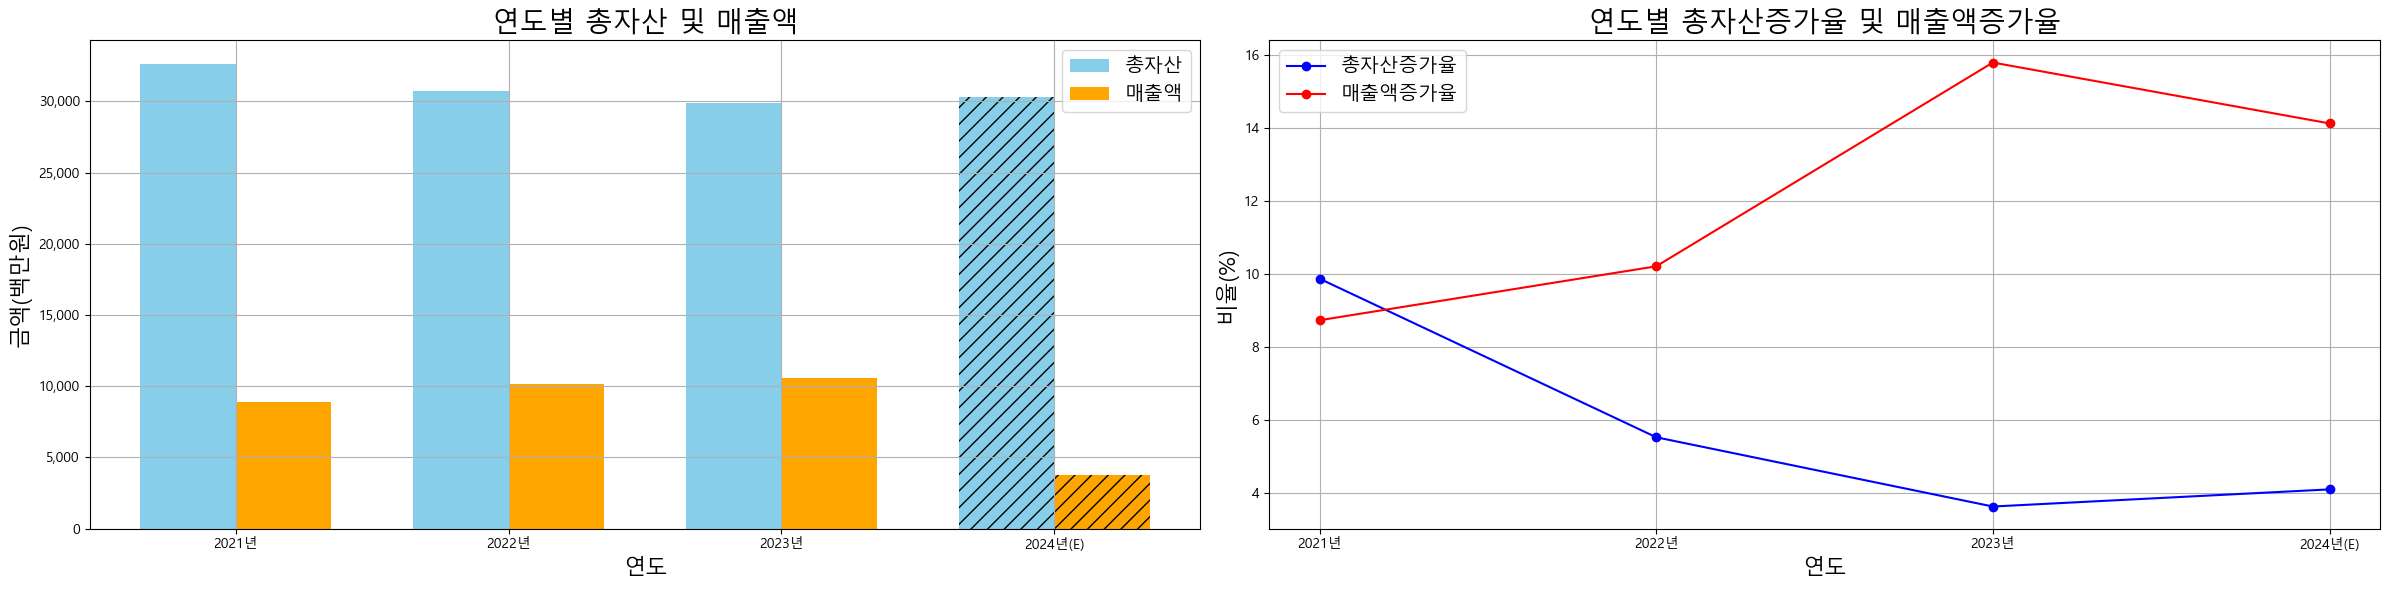

Year Level DataFrame (Pivoted):
연도     2021년     2022년     2023년  2024년(E)
매출액   8868.0  10178.67  10546.67   3794.67
총자산  32644.0  30687.00  29873.00  30297.00

Year Rate DataFrame (Pivoted):
연도      2021년  2022년  2023년  2024년(E)
매출액증가율   8.73  10.21  15.80     14.13
총자산증가율   9.87   5.52   3.62      4.09


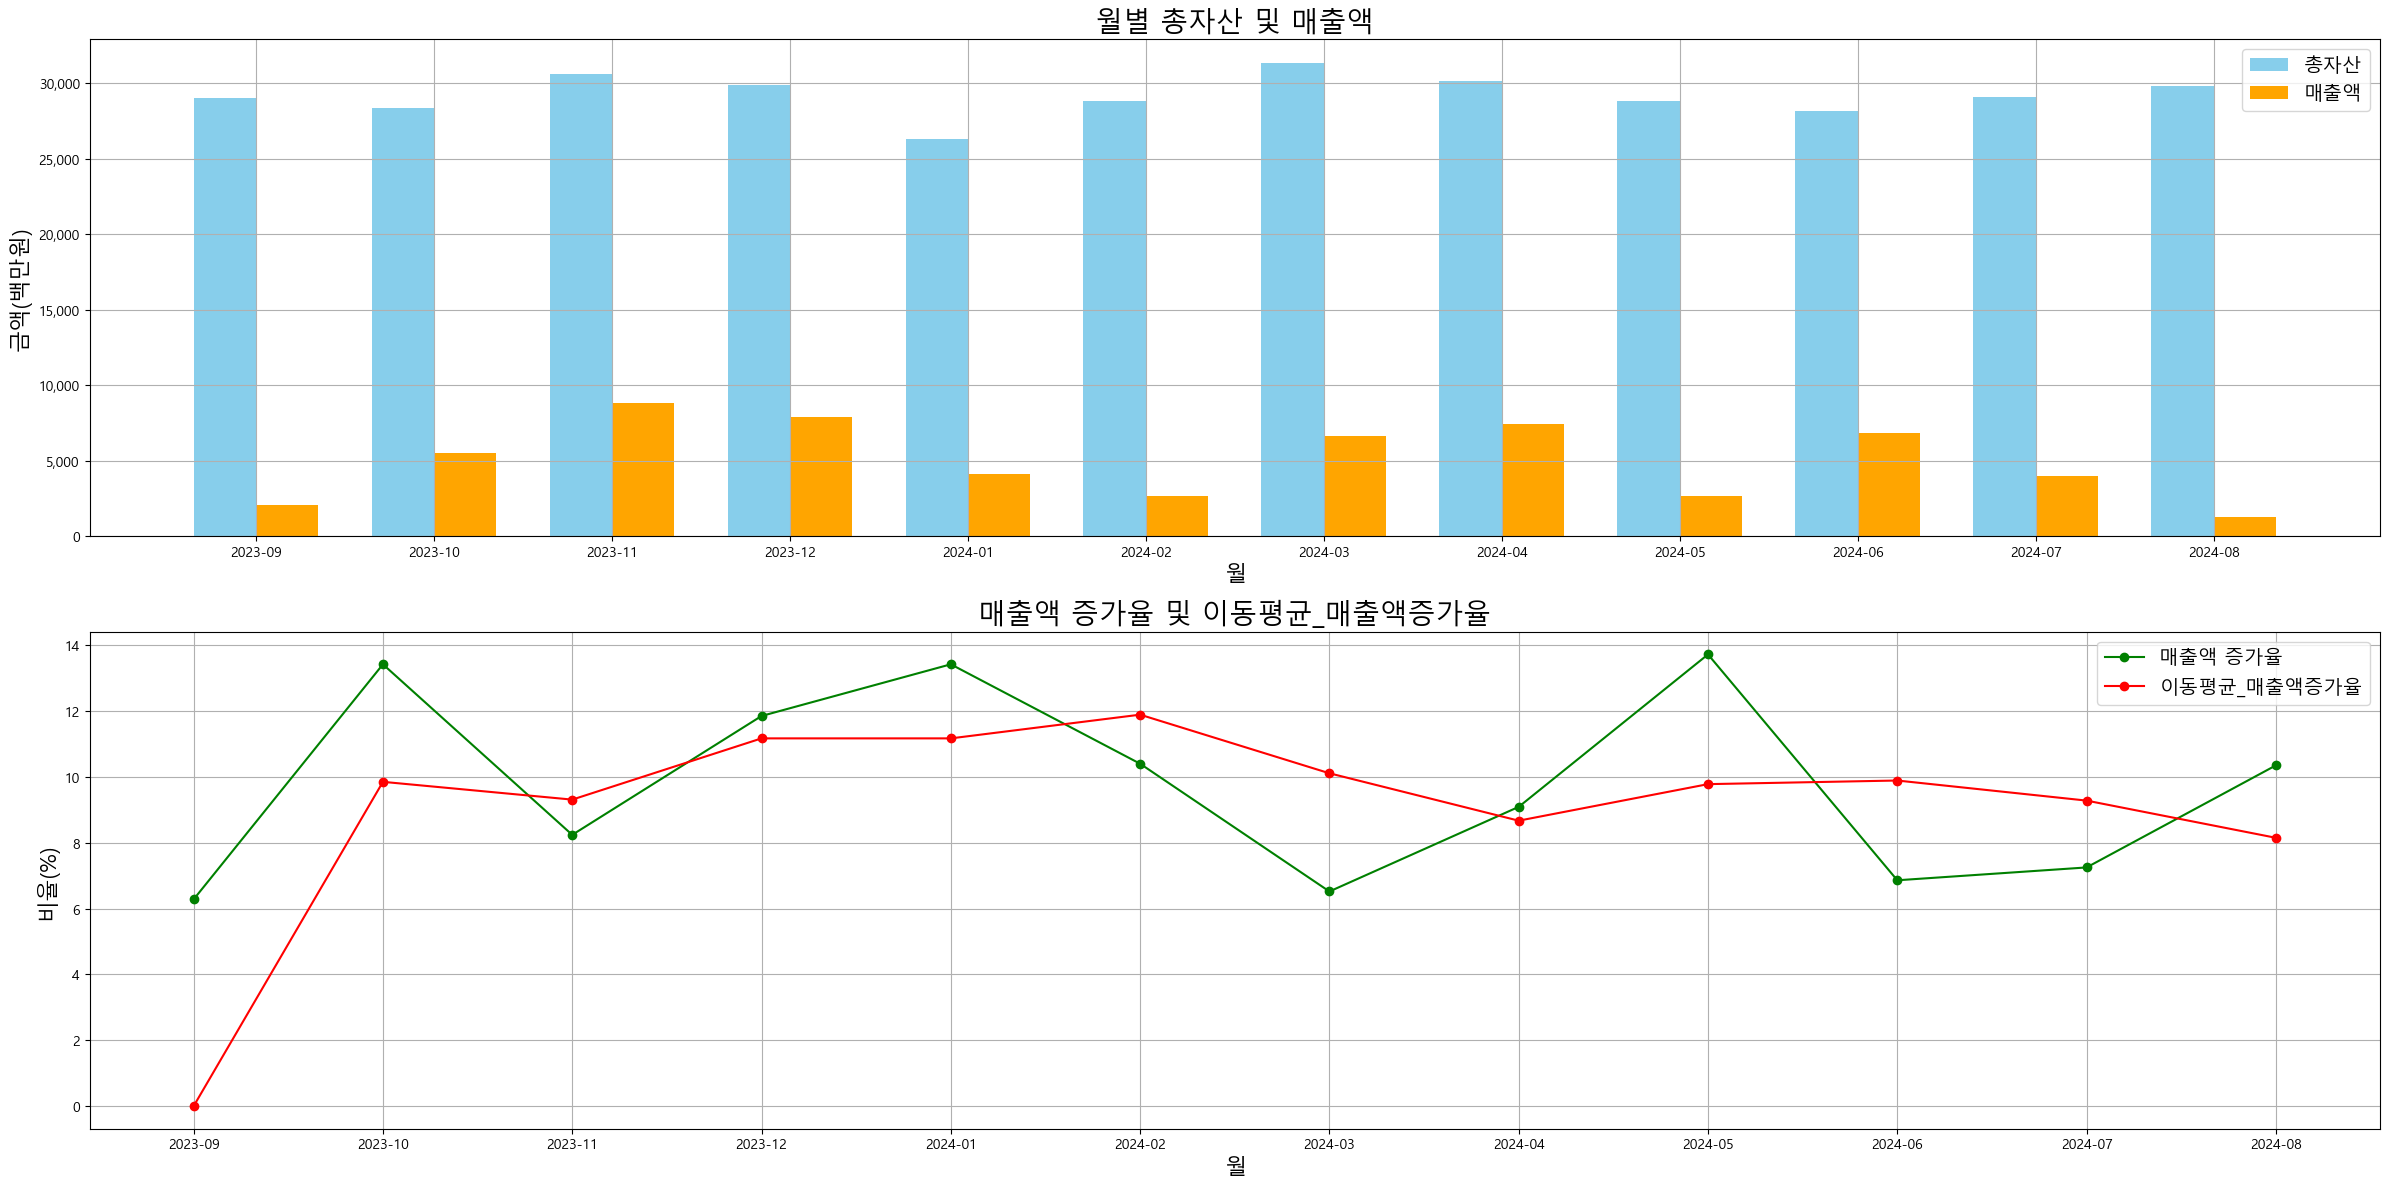


Recent DataFrame (Pivoted):
월             2023-09   2023-10   2023-11   2023-12   2024-01   2024-02  \
매출액           2078.00   5484.00   8790.00   7910.00   4140.00   2678.00   
매출액증가율           6.28     13.42      8.24     11.85     13.42     10.40   
이동평균_매출액증가율      0.00      9.85      9.31     11.17     11.17     11.89   
총자산          29030.00  28378.00  30585.00  29873.00  26293.00  28805.00   

월             2024-03   2024-04   2024-05   2024-06   2024-07   2024-08  
매출액           6618.00   7427.00   2634.00   6862.00   4017.00   1305.00  
매출액증가율           6.52      9.09     13.72      6.86      7.25     10.35  
이동평균_매출액증가율     10.11      8.67      9.78      9.89      9.28      8.15  
총자산          31339.00  30143.00  28839.00  28133.00  29118.00  29800.00  
##############################

Company_1에 대한 AI 답변:
2024년 예상치에 따르면 총자산은 30,297백만 원으로 2023년의 29,873백만 원에서 소폭 증가할 것으로 보이며, 매출액은 3,794.67백만 원으로 2023년의 10,546.67백만 원에 비해 크게 감소할 것으로 예상됩니다. 연도별 성장률을 살펴보면, 2023년 총자산 증가율은 3.62%로 202

In [10]:
# 10개 회사 sample
company_list = df_company_info['기업명'].unique()[:1]

for firm in company_list:
    print("\n\n",'#'*10, f'{firm}', '#'*10)
    temp = df_company_info[df_company_info['기업명'] == firm]
    
    # 성장성 지표 JSON 데이터 생성
    growth_data = preprocess_growth_data(temp)  # 이전 코드에서 생성된 성장성 지표 데이터
    
    json_to_dataframe(growth_data)
    
    # 성장성 지표에 대한 분석 요청
    result = growth_analysis_chain.stream({
        "latest_year_month": growth_data["latest_year_month"],
        "year_level_data": growth_data["year_level_data"],
        "year_rate_data": growth_data["year_rate_data"],
        "recent_data": growth_data["recent_data"]
    })

    # Streaming
    print( f"\n{firm}에 대한 AI 답변:")
    stream_response(result)

In [32]:
pprint.pprint(growth_data)

{'latest_year_month': '2024-09',
 'recent_data': {'2023-09': {'매출액': 6101,
                             '매출액증가율': 7.0,
                             '이동평균_매출액증가율': 0.0,
                             '총자산': 32090,
                             '총자산증가율': 5.89},
                 '2023-10': {'매출액': 4700,
                             '매출액증가율': 11.46,
                             '이동평균_매출액증가율': 9.23,
                             '총자산': 29841,
                             '총자산증가율': 4.75},
                 '2023-11': {'매출액': 4695,
                             '매출액증가율': 8.46,
                             '이동평균_매출액증가율': 8.97,
                             '총자산': 31858,
                             '총자산증가율': 5.5},
                 '2023-12': {'매출액': 8841,
                             '매출액증가율': 12.32,
                             '이동평균_매출액증가율': 10.75,
                             '총자산': 31544,
                             '총자산증가율': 5.69},
                 '2024-01': {'매출액': 5532,
                     

Year Level DataFrame:
         연도    총자산       매출액
0     2023년  31544  11788.00
1     2022년  30489   3210.67
2     2021년  30860  10460.00
3  2024년(E)  31000  11594.67

Year Rate DataFrame:
         연도  총자산증가율  매출액증가율
0     2023년    5.69   16.43
1     2022년    4.22   16.87
2     2021년    5.24   19.48
3  2024년(E)    3.97   18.27

Recent Data DataFrame:
          월    총자산  총자산증가율   매출액  매출액증가율  이동평균_매출액증가율
0   2023-09  32090    5.89  6101    7.00         0.00
1   2023-10  29841    4.75  4700   11.46         9.23
2   2023-11  31858    5.50  4695    8.46         8.97
3   2023-12  31544    5.69  8841   12.32        10.75
4   2024-01  27616    8.62  5532    7.69         9.49
5   2024-02  30870    5.21  7592    5.38         8.46
6   2024-03  31572    5.54  7953    9.75         7.61
7   2024-04  28159    9.87  2543    7.61         7.58
8   2024-05  31951    7.96  1295   12.32         9.89
9   2024-06  29735    5.05  3908    7.60         9.18
10  2024-07  27069    7.74  1862    7.21         9.04

TypeError: can only concatenate str (not "float") to str

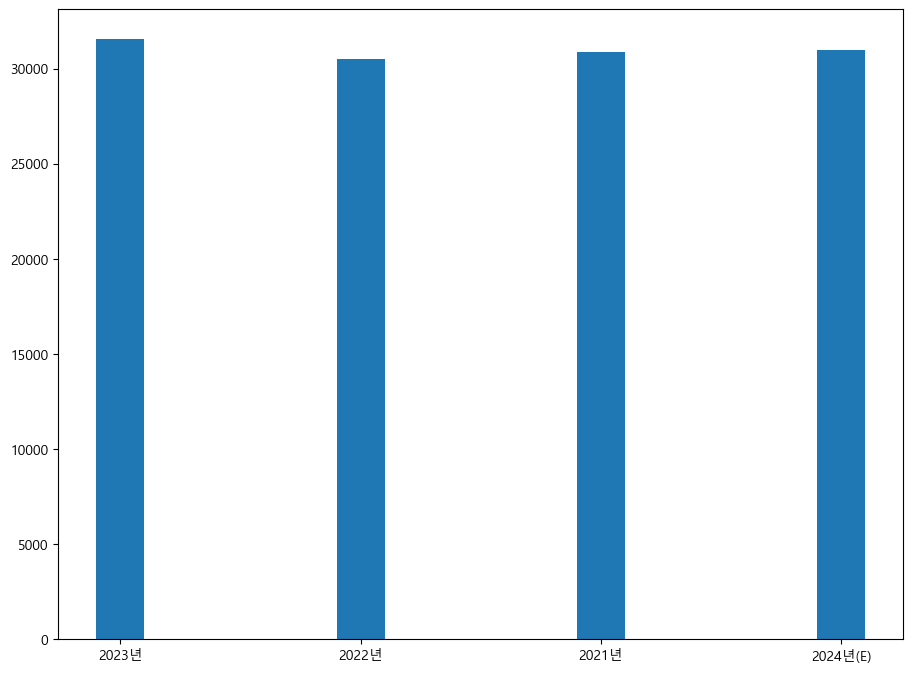

In [31]:
def graph_generator_example(data):
    """
    Generate graphs based on financial data.
    The input should be a JSON string or a dictionary.
    """
    # data가 문자열이면 JSON으로 변환
    if isinstance(data, str):
        data_dict = json.loads(data)
    else:
        data_dict = data
    
    year_level_df, year_rate_df, rate_data_df = data['year_level_df'], data['year_rate_df'], data['recent_data_df']

    # 전체 Figure 생성
    fig = plt.figure(figsize=(24, 18))

    # 1. year_level_data를 가지고 막대그래프 그리기 - 왼쪽 상단
    ax1 = fig.add_subplot(2, 2, 1)
    bar_width = 0.2
    ax1.bar(year_level_df['연도'], year_level_df['총자산'], width=bar_width, label='총자산', align='center')
    ax1.bar(year_level_df['연도'] + bar_width, year_level_df['매출액'], width=bar_width, label='매출액', align='center')
    ax1.set_title('연도별 총자산 및 매출액')
    ax1.set_xlabel('연도')
    ax1.set_ylabel('금액(백만원)')
    ax1.legend()
    ax1.grid(True)

    # 2. year_rate_data를 가지고 점이 있는 꺾은선 그래프 그리기 - 오른쪽 상단
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.plot(year_rate_df['연도'], year_rate_df['총자산증가율'], marker='o', label='총자산증가율', color='blue')
    ax2.plot(year_rate_df['연도'], year_rate_df['매출액증가율'], marker='o', label='매출액증가율', color='red')
    ax2.set_title('연도별 총자산증가율 및 매출액증가율')
    ax2.set_xlabel('연도')
    ax2.set_ylabel('비율(%)')
    ax2.legend()
    ax2.grid(True)

    # 3. recent_data를 가지고 2개의 subplot이 있는 그림 그리기 - 아래쪽
    recent_data_df.set_index('월', inplace=True)
    months = np.arange(len(recent_data_df.index))  # 월을 숫자 인덱스로 변환
    month_labels = recent_data_df.index  # 실제 월 라벨
    total_assets = recent_data_df['총자산']  # 총자산
    sales = recent_data_df['매출액']  # 매출액
    growth_rate_sales = recent_data_df['매출액증가율']  # 매출액 증가율
    moving_avg_sales_growth = recent_data_df['이동평균_매출액증가율']  # 3개월 이동평균 매출액 증가율

    # 세 번째 subplot: 총자산과 매출액 (막대 그래프) - 아래 왼쪽
    ax3 = fig.add_subplot(4, 1, 3)
    bar_width = 0.35
    ax3.bar(months - bar_width/2, total_assets, width=bar_width, label='총자산', color='skyblue')
    ax3.bar(months + bar_width/2, sales, width=bar_width, label='매출액', color='orange')
    ax3.set_title('월별 총자산 및 매출액')
    ax3.set_xlabel('월')
    ax3.set_ylabel('금액')
    ax3.set_xticks(months)
    ax3.set_xticklabels(month_labels)
    ax3.legend()
    ax3.grid(True)

    # 네 번째 subplot: 매출액 증가율과 이동평균_매출액증가율 (꺾은선 그래프) - 아래 오른쪽
    ax4 = fig.add_subplot(4, 1, 4)
    ax4.plot(month_labels, growth_rate_sales, marker='o', label='매출액 증가율', color='green')
    ax4.plot(month_labels, moving_avg_sales_growth, marker='o', label='이동평균_매출액증가율', color='red')
    ax4.set_title('매출액 증가율 및 이동평균_매출액증가율')
    ax4.set_xlabel('월')
    ax4.set_ylabel('비율')
    ax4.legend()
    ax4.grid(True)

    plt.tight_layout()
    plt.show()
    
graph_generator_example(growth_data)